In [3]:
import numpy as np

In [2]:
import networkx as nx

In [1]:
import matplotlib.pyplot as plt
import random
import time
import math

In [6]:
#plt.subplot()

In [59]:
def givemedag(v,e,c):
    if e < v-1:
        print('边太少')
        return None
    #e大小要适量
    D = nx.DiGraph()
    leaves=[]
    while(True):
        nx.generators.directed.gn_graph(v-1,kernel = lambda x :2**x,create_using = D)
        tmp = [x[0] for x in list(D.in_degree()) if x[1] == 0]
        leafnum = len(tmp)
        if D.number_of_edges() + leafnum <= e:
            leaves = tmp.copy()
            break
    #nx.draw(D,with_labels=True)
    
    my_dict = nx.shortest_path_length(nx.reverse_view(D),source=0)
    mylst = list(zip(my_dict.values(), my_dict.keys()))
    #print(my_dict)
    #print(mylst)
    #print(leaves)
    D.add_node(v-1)
    for each in leaves:
        fea = [x[1] for x in mylst if x[0]>my_dict[each]]
        fea.append(v-1)
        D.add_edge(random.choice(fea),each)
    return D.reverse()

In [8]:
def allocation(dag,agentinfo,timelimit):
    basebid = {}
    relativebid = []
    welfare = 0.0
    for e in list(dag.edges):
        agentinfo[e].sort(key = lambda x:x[1])
        basebid[e] = agentinfo[e][0][0]
        nowbid = basebid[e]
        for i in range(len(agentinfo[e])):
            if i > 0 and agentinfo[e][i][0] > nowbid:
                nowbid = agentinfo[e][i][0]
                relativebid.append((agentinfo[e][i][0]-basebid[e],agentinfo[e][i][1],agentinfo[e][i][2],agentinfo[e][i][3]))
        dag.edges[e[0],e[1]]['weight'] = agentinfo[e][0][1]
        welfare = welfare + agentinfo[e][0][0]
    #print(relativebid)
    #if nx.dag_longest_path_length(dag) > timelimit:
    #    print('mission impossible')
    #    return -1
    vis = {}
    relativebid.sort(key = lambda x:x[0])
    while relativebid != []:
        if len(vis) == dag.number_of_edges():
            break
        item = relativebid.pop()
        if item[2] in vis:
            continue
        tmp = dag.edges[item[2][0],item[2][1]]['weight']
        dag.edges[item[2][0],item[2][1]]['weight'] = item[1]
        if nx.dag_longest_path_length(dag) > timelimit:
            dag.edges[item[2][0],item[2][1]]['weight'] = tmp
            continue
        welfare = welfare + item[0]
        vis[item[2]] = True
    return welfare

In [9]:
def dfs(dag,ind,agentinfo,timelimit,welfare):
    if ind == dag.number_of_edges():
        if nx.dag_longest_path_length(dag) > timelimit:
            return -1
        return welfare
    te=list(dag.edges)[ind]
    ms = 0.0
    for x in agentinfo[te]:
        dag.edges[te[0],te[1]]['weight'] = x[1]
        ms = max(ms,dfs(dag,ind+1,agentinfo,timelimit,welfare+x[0]))
    return ms

In [10]:
def brute(dag,agent,timelimit):
    agentinfo = agent.copy()
    for e in list(dag.edges):
        agentinfo[e].sort(key = lambda x:x[1]) 
        filt = [agentinfo[e][i] for i in range(len(agentinfo[e]))if i == 0 or agentinfo[e][i][0] > agentinfo[e][i-1][0]]
        agentinfo[e] = filt
    return dfs(dag,0,agentinfo,timelimit,0)

In [11]:
def givemeagent(E, C):
    agents = {}
    for e in E:
        ci = np.random.randint(1,C)
        agents[e]=[]
        for i in range(ci):
            bi = -1
            while bi < 0:
                bi = 1*np.random.randn()+50
            ti = -1
            while ti <0:
                ti = np.random.randint(1,100)
            agents[e].append((bi,ti,e,i))
    return agents

In [72]:
def check(n,C):
    aoe = givemedag(n,1000000000,3)
    assert nx.is_directed_acyclic_graph(aoe)
    #print(aoe.number_of_edges())
    #nx.draw(aoe,with_labels=True)

    es = list(aoe.edges)
    agents = givemeagent(es,C)
    ms = {}
    for e in es:
        agents[e].sort(key = lambda x:x[1])
        nowbid = agents[e][0][0]
        mis = agents[e][0][1]
        mas = agents[e][0][1]
        for i in range(len(agents[e])):
            if i > 0 and agents[e][i][0] > nowbid:
                nowbid = agents[e][i][0]
                mas = agents[e][i][1]
        ms[e] = (mis,mas)
    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][0]
    a = nx.dag_longest_path_length(aoe)

    for e in es:
        aoe.edges[e[0],e[1]]['weight'] = ms[e][1]
    b = nx.dag_longest_path_length(aoe)

    tl = np.random.randint(a,b+1)
    
    t0 = time.perf_counter()
    sf = allocation(aoe,agents,tl),
    
    return sf,time.perf_counter()-t0
    #return allocation(aoe,agents,tl),brute(aoe,agents,tl)

In [54]:
a,b = check(20,3)
print(a,b)

32
1617.0194272278704 1617.0194272278704


10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
28

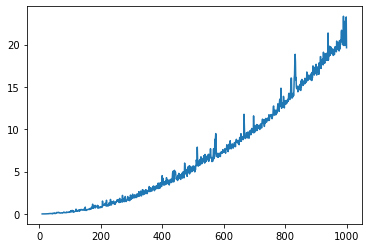

In [73]:
lst = []
a = []
for x in range(10,10**3):
    print(x)
    a.append(x)
    c,d = check(x,10)
    lst.append(d)
plt.plot(a,lst)

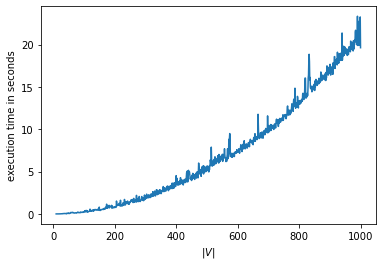

In [81]:
plt.xlabel('$|V|$')
plt.ylabel('execution time in seconds')
plt.plot(a,lst)
plt.savefig('exetime.pdf')
plt.show()

In [75]:
import pandas as pd

In [76]:
df = pd.DataFrame({'x':a,'y':lst})
df.to_csv('exetime10-1000.csv',index=False)

In [ ]:

testn=[10,15,20]
for x in testn:
    ratiolist = []
    cnt = 0
    for i in range(1000):
        print(i)
        a,b = check(x,3)
        if math.fabs(a-b) < 1e-8:
            cnt=cnt+1
        ratiolist.append(a/b)
        
        #print("a/b=%lf"%(a/b))
    print(cnt,np.median(ratiolist),np.mean(ratiolist),np.std(ratiolist,ddof=1))


In [ ]:
998 1.0 0.9999980277131707 5.478483267317938e-05

994 1.0 0.999998769926064 1.8107295551290027e-05
992 1.0 0.9999979986019756 2.9445272088786218e-05


In [ ]:
print(cnt,np.median(ratiolist),np.mean(ratiolist),np.std(ratiolist,ddof=1))

In [16]:
len(ratiolist)

1

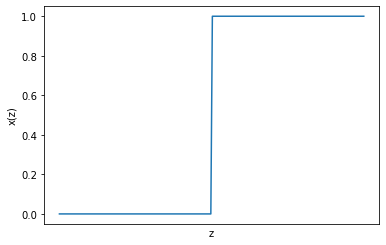

In [12]:
x = np.linspace(0,2,200)
z = np.zeros(100)
o = np.ones(100)
y = np.concatenate([z,o])
plt.xlabel('z')
plt.ylabel('x(z)')
plt.xticks([])
plt.plot(x,y)
plt.savefig('jieyuefenpei.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

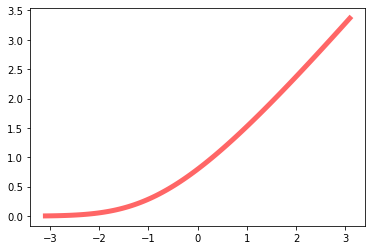

In [13]:
fig, ax = plt.subplots(1, 1)
from scipy.stats import norm
x = np.linspace(norm.ppf(0.001),
                norm.ppf(0.999), 100)
ax.plot(x, norm.pdf(x)/(1-norm.cdf(x)),
       'r-', lw=5, alpha=0.6, label='norm pdf')